# SIGNATURE BASED INTRUSION DETECTION SYSTEM

## Importing Libraries

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

## Reading the Dataset

In [24]:
df = pd.read_csv("CIC-TON-IOT_sample_km.csv")

### Train Test Split

In [25]:
train, test = train_test_split(df, test_size = 0.2)

### Attack Class Distribution

In [26]:
train['Attack'].value_counts()

Attack
0    16136
9    13651
6     2190
4     1819
5      426
8      252
1      167
2      166
3      108
7       29
Name: count, dtype: int64

### Standardizing the Data

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [28]:
enctrain = sc_traindf
enctrain.shape

(34944, 81)

In [29]:
train_x = sc_traindf
train_y = train['Attack']

## Feature Engineering

### Using Mean Decrease in Impurity

In [30]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(train_x, train_y);

### Extract Important feature from it

In [31]:
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

### Plotting the importances 

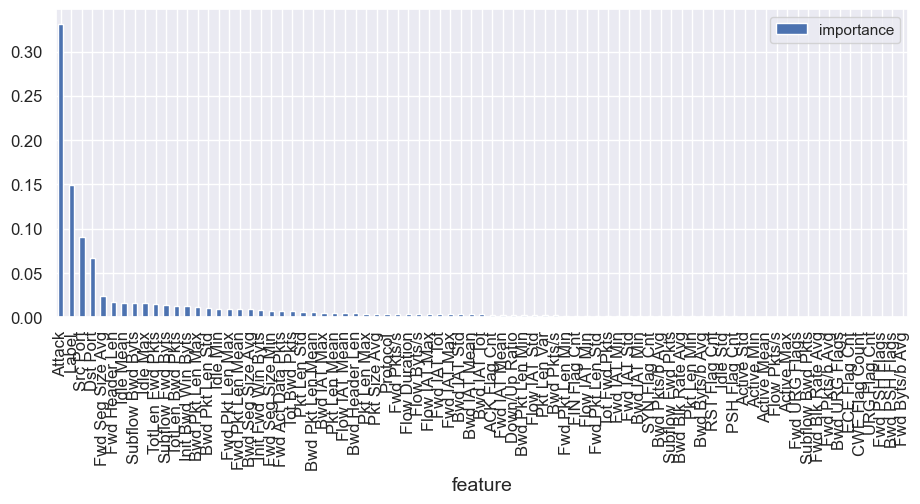

In [32]:
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

## Selecting 30 feature from it

In [33]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=30)
rfe = rfe.fit(train_x, train_y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['Src Port',
 'Dst Port',
 'Flow Duration',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Std',
 'Flow IAT Max',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Bwd IAT Tot',
 'Bwd IAT Max',
 'Fwd Header Len',
 'Bwd Header Len',
 'Bwd Pkts/s',
 'Pkt Len Std',
 'Fwd Seg Size Avg',
 'Subflow Fwd Byts',
 'Subflow Bwd Byts',
 'Init Fwd Win Byts',
 'Init Bwd Win Byts',
 'Fwd Seg Size Min',
 'Idle Mean',
 'Idle Max',
 'Idle Min',
 'Label',
 'Attack']

In [34]:
train_x_df = pd.DataFrame(train_x, columns=selected_features)             #updated.
train_y_df = pd.DataFrame(train_y, columns=selected_features)

## Train Test Split

In [35]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

## Importing the Classifiers

In [36]:
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [37]:
X_train_array = X_train.values
X_test_array = X_test.values

### Training Accuracies


============================== Naive Bayes Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.6084627964022894

Model Accuracy:
 0.610874897792314

Confusion matrix:
 [[9872    4  133   42 1069   20    0  122   21    0]
 [   0  108    0    0    0    1    0    1    0    0]
 [   0    0   93   17    0    1    0    0    0    0]
 [   0    0   59   14    0    1    0    0    0    0]
 [ 333    4   81    2  860    1    1    1   11    0]
 [   0   21  119   20    0   63   32   17    0   28]
 [   2    1    2    0    0    6  991    4   35  475]
 [   1    1    1    0    0    1    0   12    0    4]
 [   1    0   45    0    0    3   72    2   16   44]
 [  22    7 2483    0    0  152 3856   74   62 2913]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.92     11283
           1       0.74      0.98      0.84       110
           2       0.03      0.84      0.06       111
           3      

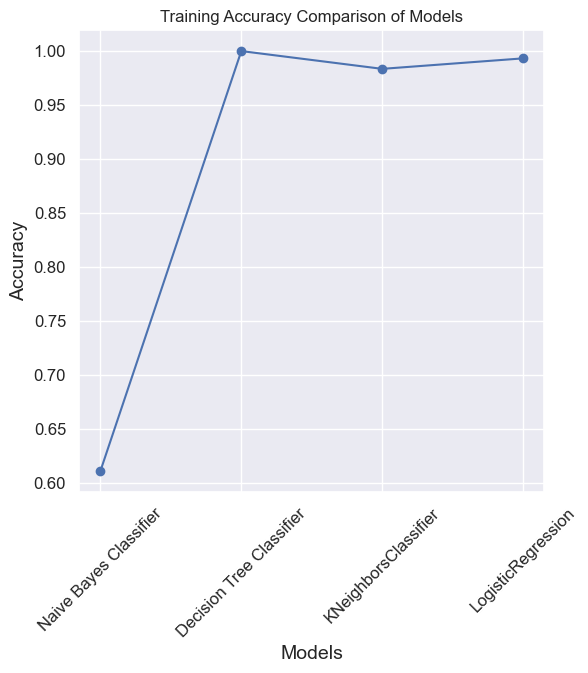

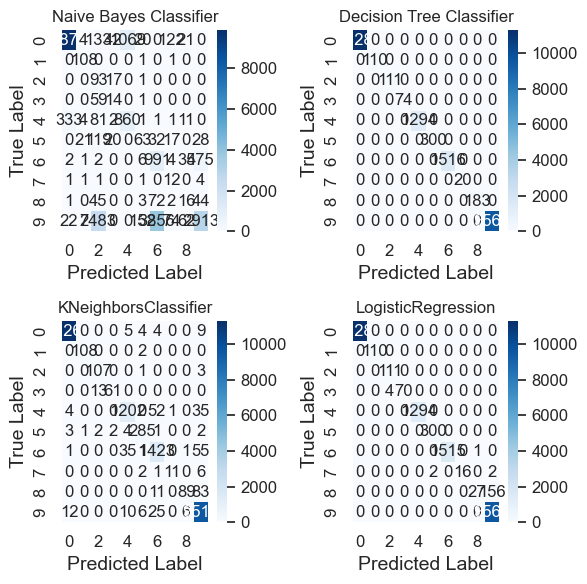

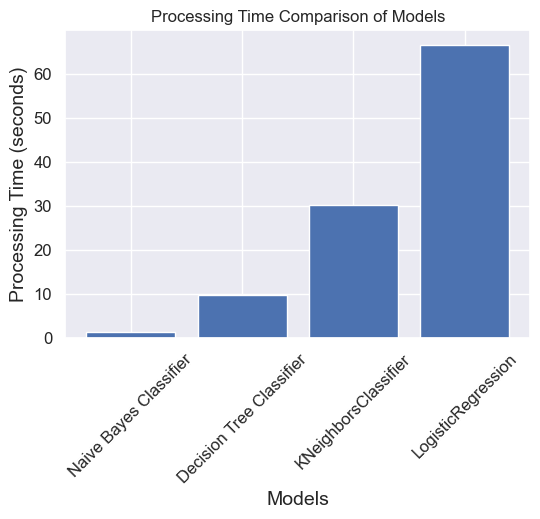

In [38]:
from sklearn import metrics
import time

models = []
models.append(('Naive Bayes Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

accuracy_scores = []
confusion_matrices = []
processing_times = []

for i, v in models:
    start_time = time.time()  # Start measuring time
    
    scores = cross_val_score(v, X_train_array, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train_array))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train_array))
    classification = metrics.classification_report(Y_train, v.predict(X_train_array))
    
    end_time = time.time()  # Stop measuring time
    processing_time = end_time - start_time
    processing_times.append(processing_time)
    
    accuracy_scores.append(accuracy)
    confusion_matrices.append(confusion_matrix)
    
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print("Cross Validation Mean Score:\n", scores.mean())
    print()
    print("Model Accuracy:\n", accuracy)
    print()
    print("Confusion matrix:\n", confusion_matrix)
    print()
    print("Classification report:\n", classification)
    print("Processing Time: {:.4f} seconds".format(processing_time))
    print()

# Plotting line curve for accuracy values
plt.figure(figsize=(6, 6))
models_names = [model[0] for model in models]
plt.plot(models_names, accuracy_scores, marker='o')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison of Models')
plt.xticks(rotation=45)
plt.show()

# Creating heatmap for confusion matrices
plt.figure(figsize=(6, 6))
for i, matrix in enumerate(confusion_matrices):
    plt.subplot(2, 2, i+1)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(models[i][0])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Displaying processing times as a bar graph
plt.figure(figsize=(6, 4))
plt.bar(models_names, processing_times)
plt.xlabel('Models')
plt.ylabel('Processing Time (seconds)')
plt.title('Processing Time Comparison of Models')
plt.xticks(rotation=45)
plt.show()

In [39]:
from sklearn.ensemble import VotingClassifier

# Define the voting classifier
voting_clf = VotingClassifier(estimators=models, voting='hard')


start_time = time.time()  # Start the timer
# Train the voting classifier
voting_clf.fit(X_train, Y_train)
end_time = time.time()  # Stop the timer
training_time = end_time - start_time  # Calculate training time

# Add the ensemble model's training time to the overall training time
model_training_times.append(training_time)
# Calculate the total training time by summing the individual model training times
overall_training_time = sum(model_training_times)

# Evaluate the voting classifier
scores = cross_val_score(voting_clf, X_train_array, Y_train, cv=10)
accuracy = metrics.accuracy_score(Y_train, voting_clf.predict(X_train_array))
confusion_matrix = metrics.confusion_matrix(Y_train, voting_clf.predict(X_train_array))
classification = metrics.classification_report(Y_train, voting_clf.predict(X_train_array))

print()
print('============================== Ensemble Model Evaluation ==============================')
print()
print("Cross Validation Mean Score:" "\n", scores.mean())
print()
print("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification)
print()
print(f"Training Time for Ensemble Model: {overall_training_time} seconds")



============================== Ensemble Model Evaluation ==============================

Cross Validation Mean Score:
 0.9926410466067047

Model Accuracy:
 0.9955437448896157

Confusion matrix:
 [[11283     0     0     0     0     0     0     0     0     0]
 [    0   110     0     0     0     0     0     0     0     0]
 [    0     0   111     0     0     0     0     0     0     0]
 [    0     0     6    68     0     0     0     0     0     0]
 [    0     0     0     0  1294     0     0     0     0     0]
 [    0     0     0     1     0   299     0     0     0     0]
 [    0     0     1     0     0     0  1515     0     0     0]
 [    0     0     1     0     0     1     0    16     0     2]
 [    0     0     0     0     0     0     2     0   108    73]
 [    0     0     0     0     0     0    16     0     6  9547]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11283
           1       1.00      1.00      

### Testing Accuracies

In [40]:
model_testing_times = []
for i, v in models:
    start_time = time.time()  # Start the timer
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test_array))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test_array))
    classification = metrics.classification_report(Y_test, v.predict(X_test_array))
    end_time = time.time()  # Stop the timer
    testing_time = end_time - start_time  # Calculate training time
    model_testing_times.append(testing_time)  # Store the training time
    
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Bayes Classifier Model Test Results ==============================

Model Accuracy:
 0.6126478443342236

Confusion matrix:
 [[4253    6   63   17  454   12    0   41    7    0]
 [   0   57    0    0    0    0    0    0    0    0]
 [   0    0   42   12    0    1    0    0    0    0]
 [   0    0   27    7    0    0    0    0    0    0]
 [ 132    0   31    0  352    2    1    1    6    0]
 [   0   16   52    2    0   20   16   10    0   10]
 [   2    0    1    0    0    1  450    0   10  210]
 [   0    0    0    0    0    1    1    3    0    4]
 [   0    0   13    0    0    1   32    1    4   18]
 [   4    4 1107    2    0   58 1620   25   27 1235]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      4853
           1       0.69      1.00      0.81        57
           2       0.03      0.76      0.06        55
           3       0.17      0.21      0.19        34
           

In [41]:
from sklearn.ensemble import VotingClassifier

# Define the voting classifier
voting_clf = VotingClassifier(estimators=models, voting='hard')

start_time = time.time()  # Start the timer
# Train the voting classifier
voting_clf.fit(X_test, Y_test)
end_time = time.time()  # Stop the timer
testing_time = end_time - start_time  # Calculate training time

# Add the ensemble model's training time to the overall training time
model_testing_times.append(testing_time)
# Calculate the total training time by summing the individual model training times
overall_testing_time = sum(model_testing_times)

# Evaluate the voting classifier
scores = cross_val_score(voting_clf, X_test_array, Y_test, cv=10)
accuracy = metrics.accuracy_score(Y_test, voting_clf.predict(X_test_array))
confusion_matrix = metrics.confusion_matrix(Y_test, voting_clf.predict(X_test_array))
classification = metrics.classification_report(Y_test, voting_clf.predict(X_test_array))

print()
print('============================== Ensemble Model Evaluation ==============================')
print()
print("Cross Validation Mean Score:" "\n", scores.mean())
print()
print("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification)
print()
print()
print(f"Testing Time for Ensemble Model: {overall_testing_time} seconds")



============================== Ensemble Model Evaluation ==============================

Cross Validation Mean Score:
 0.9902701773408337

Model Accuracy:
 0.9931323922167111

Confusion matrix:
 [[4853    0    0    0    0    0    0    0    0    0]
 [   0   57    0    0    0    0    0    0    0    0]
 [   0    0   55    0    0    0    0    0    0    0]
 [   0    0   20   14    0    0    0    0    0    0]
 [   0    0    0    0  525    0    0    0    0    0]
 [   0    0    1    0    0  125    0    0    0    0]
 [   0    0    0    0    0    0  673    0    1    0]
 [   0    0    0    0    0    0    0    8    0    1]
 [   0    0    1    0    0    0    4    0   26   38]
 [   0    0    0    0    0    0    6    0    0 4076]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4853
           1       1.00      1.00      1.00        57
           2       0.71      1.00      0.83        55
           3       1.00      0.